### Twitter Query
- Twitter has already been queried using the [Search Tweets API](https://dev.twitter.com/rest/reference/get/search/tweets). 
- returned JSON was written to `[query_term]_twitter_search_raw.json` file where each row in file is a tweet json object
- below is a query example

```python
import requests
from requests_oauthlib import OAuth1
import json

#define API url
url = 'https://api.twitter.com/1.1/search/tweets.json'

#define credentials
auth = OAuth1(consumer_key, consumer_secret, access_token, access_token_secret)

query_term = input('Enter Twitter Search Term: ')

#define file for writing
json_f = open('[%s]_twitter_search_raw.json % query_term, 'a')

#writing decorator function    
def append_record(record):
    json_f.write(json.dumps(record, sort_keys=True))
    json_f.write('\n')
    json_f.flush()

#loop start here

#query parameters
payload = {'lang' : 'en', 'count' : 100, 'q' : query_term}

#make request
r = requests.get(url, params = payload, auth = auth)

#check status
#backoff when required

rj = r.json()

for result in rj['statuses']:
    append_record(result)

#loop

json_f.close()
```

* to automate for historical searching, simply loop the call [(note limits and good practices)](https://dev.twitter.com/rest/public)
* and recursively update payload max_id with latest tweet id
* alternatively for online data, use streaming api [(documentation)](https://dev.twitter.com/streaming/overview)

### Twitter Processing
* the below scripts transform JSON to clean database for later analysis
#### import tools

In [1]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
from pandas.tseries.offsets import *
import re
import csv

In [2]:
#import plotting library
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

#### define output database
- tweet object looks like: ([documentation](https://dev.twitter.com/overview/api/tweets))

```
['contributors',
 'coordinates',
 'created_at',
 'entities',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'metadata',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'source',
 'text',
 'truncated',
 'user']
```

- list below is final columns we want
- added our own extracted columns
- dropped large dictionaries (entities, user)
- dropped others we don't want like deprecated geo, others like metadata, reply/quoted_status etc.

In [3]:
cols = [
    'id_str',
    'created_at',
    'source',
    'longitude',
    'latitude',
    'place_country',
    'place_name',
    'text',
    'lang',
    'tweet_type',
    'possibly_sensitive',
    'is_retweet',
    'is_reply',
    'is_quoted_tweet',
    'entities_media',
    'entities_urls',
    'entities_mentions',
    'entities_hashtags',
    'favorite_count',
    'retweet_count',
    'user_id_str',
    'user_screen_name',
    'user_created_at',
    'user_description',
    'user_location',
    'user_default_profile',
    'user_default_profile_image',
    'user_verified',
    'user_statuses',
    'user_favourites',
    'user_followers',
    'user_friends',
    'user_listed']

#### convert query term to file name keyword

In [4]:
keyword = input('Enter Twitter Query Term: ')

Enter Twitter Query Term: #CHETOT


In [5]:
keyword = keyword.replace(' ', '_').lower()
print(keyword)

#chetot


#### import data
- print cpu time to read json lines (can we make this faster?)
- flattening json tree to df will result in some columns remaining as nested dictionaries

In [6]:
%%time
raw_data = []
with open('data/[%s]_twitter_search_raw.json' % keyword) as f:
    for line in f:
        raw_data.append(json.loads(line))

Wall time: 2.71 s


#### convert list to pandas dataframe

In [7]:
df = pd.DataFrame(raw_data)

#### dedupe
- on twitter id, in case of searching errors

In [8]:
df.drop_duplicates('id_str', inplace=True)
df.shape

(29859, 29)

In [9]:
df.head(1)

,contributors,coordinates,created_at,entities,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,scopes,source,text,truncated,user
0,None,None,2016-05-03 23:57:57,"{'user_mentions': [{'id_str': '509956457', 'sc...",1,False,None,727648422103289857,727648422103289857,None,...,NaN,NaN,NaN,1,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",#legendary #footballer @jksheva7 &amp; @priyes...,False,"{'lang': 'en', 'profile_text_color': '333333',..."


#### clean text field
- remove new lines, carriage returns

In [10]:
df['text'] = df['text'].apply(lambda s: s.replace('\n', ' ').replace('\r', ' '))

#### source
- extract source text from html source object

In [11]:
df['source'] = df['source'].apply(lambda s: BeautifulSoup(s, 'html.parser').text)

#### coordinates
- extract lat, lon from tweet if known, else NaN

In [12]:
df['longitude'] = df['coordinates'].apply(lambda c: (c['coordinates'][0] if c != None else np.nan))
df['latitude'] = df['coordinates'].apply(lambda c: (c['coordinates'][1] if c != None else np.nan))

#### place
- extract place name, country if known else NaN
- place also contains geojson object, place type etc. ((documentation)[https://dev.twitter.com/overview/api/places])

In [13]:
df['place_country'] = df['place'].apply(lambda p: (p['country'] if p != None else np.nan))
df['place_name'] = df['place'].apply(lambda p: (p['full_name'] if p != None else np.nan))

#### classify tweet type
- check for 'media' key in entities dictionary, else 'text'

In [14]:
df['tweet_type'] = df['entities'].apply(lambda e: ['text','media']['media' in e])

#### mark retweets
- using character matching to 'RT @' or 'RT :'

In [15]:
df['is_retweet'] = df['text'].apply(lambda t: [0,1][t.startswith(('RT @', 'RT :'))])

#### mark replies
- using twitter's 'in_reply_to_status_id' field, where not null is encoded 1 as reply

In [16]:
df['is_reply'] = df['in_reply_to_status_id'].apply(lambda r: [1,0][np.isnan(r)])

#### mark quoted tweets
- using twitter's 'quoted_status_id' field, where not null is encoded 1 as quoted tweet

In [17]:
df['is_quoted_tweet'] = df['quoted_status_id'].apply(lambda r: [1,0][np.isnan(r)])

#### transform useful data
- using twitter's nicely organized entities, user objects
- extract entities ([documentation](https://dev.twitter.com/overview/api/entities-in-twitter-objects#tweets))
- extract user info ([documentation](https://dev.twitter.com/overview/api/entities-in-twitter-objects#users))
- some info was ignored for the purpose of this project

In [18]:
#entities
df['entities_media'] = df['entities'].apply(lambda e: [media['media_url_https'] for media in (e['media'] if 'media' in e else {})])
df['entities_urls'] = df['entities'].apply(lambda e: [url for url in [urlobject['expanded_url'] for urlobject in e['urls']]])
df['entities_mentions'] = df['entities'].apply(lambda e: [mention for mention in [mentionobject['screen_name'] for mentionobject in e['user_mentions']]])
df['entities_hashtags'] = df['entities'].apply(lambda e: [tag for tag in [tagobject['text'] for tagobject in e['hashtags']]])

In [19]:
#user
df['user_id_str'] = df['user'].apply(lambda u: u['id_str'])
df['user_screen_name'] = df['user'].apply(lambda u: u['screen_name'].replace('\n', '').replace('\r', ''))
df['user_created_at'] = df['user'].apply(lambda u: pd.to_datetime(u['created_at'], format='%a %b %d %H:%M:%S +0000 %Y'))
df['user_description'] = df['user'].apply(lambda u: u['description'].replace('\n', ' ').replace('\r', ' '))
df['user_location'] = df['user'].apply(lambda u: u['location'].replace('\n', ' ').replace('\r', ' '))
df['user_default_profile'] = df['user'].apply(lambda u: u['default_profile'])
df['user_default_profile_image'] = df['user'].apply(lambda u: u['default_profile_image'])
df['user_verified'] = df['user'].apply(lambda u: u['verified'])
df['user_statuses'] = df['user'].apply(lambda u: u['statuses_count'])
df['user_favourites'] = df['user'].apply(lambda u: u['favourites_count'])
df['user_followers'] = df['user'].apply(lambda u: u['followers_count'])
df['user_friends'] = df['user'].apply(lambda u: u['friends_count'])
df['user_listed'] = df['user'].apply(lambda u: u['listed_count'])

#### apply output columns filter

In [20]:
df = df[cols]
df.shape

(29859, 33)

In [21]:
df.head(1)

,id_str,created_at,source,longitude,latitude,place_country,place_name,text,lang,tweet_type,...,user_description,user_location,user_default_profile,user_default_profile_image,user_verified,user_statuses,user_favourites,user_followers,user_friends,user_listed
0,727648422103289857,2016-05-03 23:57:57,Twitter for iPhone,NaN,NaN,NaN,NaN,#legendary #footballer @jksheva7 &amp; @priyes...,en,media,...,"FA Registered Intermediary, Part of the #OneCl...","London, England",True,False,False,56,15,75,249,0


#### (OPTIONAL)
- merge data with existing if search was not complete

In [22]:
#df_ex = pd.read_table('data/final/query_%s_data_backup.txt' % keyword, sep='\t', encoding='utf-8', header=0)
#df_ex.shape

In [23]:
#concat (sql union) new with existing
#df = pd.concat([df, df_ex])df = pd.concat([df, df_ex])
#df.shape

In [24]:
#dedupe new merged on twitter id, in case of searching errors
#df.drop_duplicates('id_str', inplace=True)
#df.shape

#### write to file

In [25]:
#write new data to file
df.to_csv('data/final/query_%s_data.txt' % keyword, sep='\t', encoding='utf-8', header=True, index=False)

#### datetime
- convert string to pandas datetime
- used for plotting, and datetime accessors
- twitter datetime was already converted to 'YYYY-MM-DD' in searching script
- alternatively, use the below twitter datetime conversion

```
pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
```

In [26]:
df.loc[:,('created_at')] = pd.to_datetime(df['created_at'])
df = df.sort_values(by='created_at', ascending=True)

#### plot timeseries of search
- get tweet volume counts on frequency level hour
- useful time groupers offset aliases: 'D'=day H'=hour 'T'=minute [documentation](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)
- note twitter times are UTC

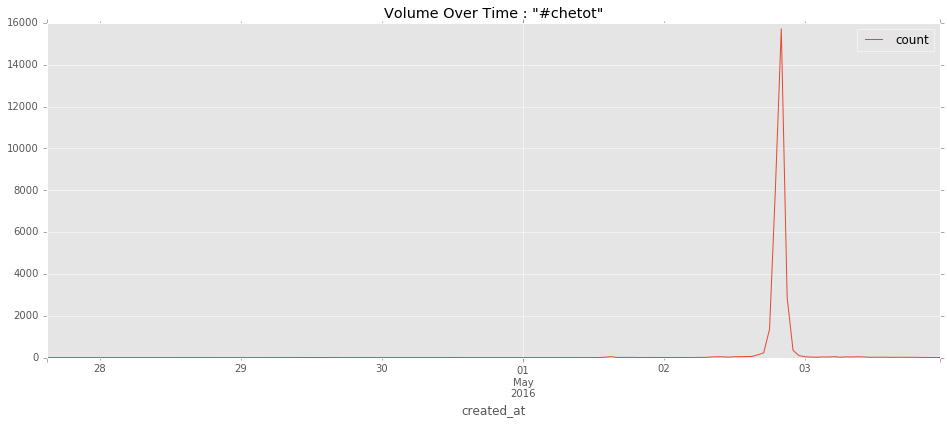

In [27]:
#reindex to datetime, groupby hour, count id's
d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['id_str'].agg(['count'])
#plot
d.plot(figsize=(16,6),
       legend=True,
       title='Volume Over Time : "%s"' % keyword)

## Define Event
#### date range
- we define the data range as -1 day to +1 day from the event date in UTC time
- this way we can comfortable handle global events
- plot tweet volume over time on minute

In [28]:
event_date = pd.to_datetime(input('Enter Event Date (YYYY-MM-DD): '))

Enter Event Date (YYYY-MM-DD): 2016-05-02


In [29]:
start = event_date - DateOffset(days=1)
finish = event_date + DateOffset(days=2)
print('START: ', start, 'FINISH: ', finish)

START:  2016-05-01 00:00:00 FINISH:  2016-05-04 00:00:00


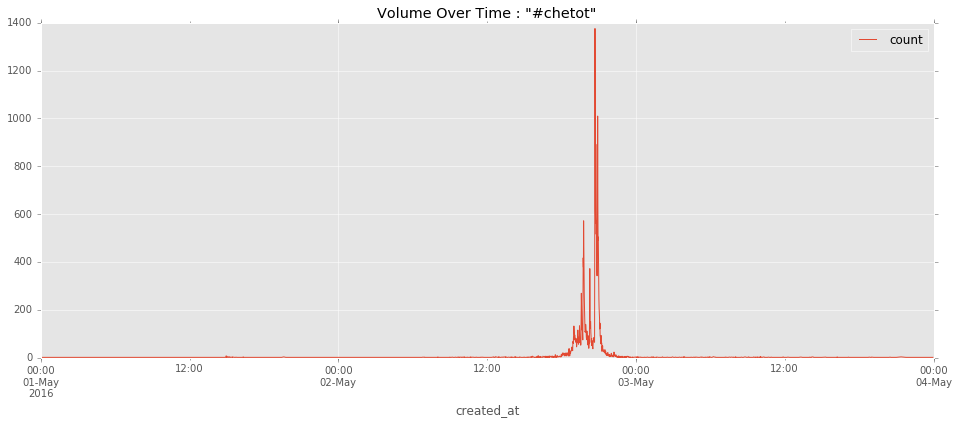

In [30]:
#reindex to datetime, groupby hour, count id's
d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='T')])['id_str'].agg(['count'])
#plot
d.plot(figsize=(16,6),
       legend=True,
       xlim=(start, finish),
       title='Volume Over Time : "%s"' % keyword)
#get current figure, save
fig = plt.gcf()
fig.savefig('query_twitter_%s.png' % keyword)

#### trim excess tweets

In [31]:
df = df[(df['created_at'] >= start) & (df['created_at'] < finish)]
df.shape

(29808, 33)

#### create master database
- add index as master id, rename twitter id
- export master event file

In [32]:
df.reset_index(drop=True, inplace=True)
df = df.reset_index().rename(columns={'index' : 'master_id', 'id_str' : 'twitter_id'})

In [33]:
event_name = input('Enter Event Name: ')
event_filename = re.sub("\W+", "", event_name.strip())
print(event_filename)

Enter Event Name: Chelsea vs. Tottenham Premier League Match
ChelseavsTottenhamPremierLeagueMatch


In [34]:
df.to_csv('data/final/event_%s_data.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)

#### get annotation data
- define data that will go to crowdflower for annotation
- exclude retweets, replies
- add event title, description
- sample 10k, set seed

In [35]:
df_forann = df[(df['is_retweet'] == 0) & (df['is_reply'] == 0)][['master_id', 'twitter_id', 'text']]

In [36]:
df_forann.loc[:,'event'] = event_name
df_forann.loc[:,'event_description'] = input('Enter Event Description: ')

Enter Event Description: The 2015–2016 Premier League is the 24th season of the Premier League, the top English professional league for association football clubs, since its establishment in 1992.


In [37]:
#no retweets, only text
df_forann_smpl = df_forann.sample(10000, random_state=2016)
#format for crowdflower import
#delimited by ;
#double quote strings
df_forann_smpl.to_csv('data/final/event_%s_annsample.csv' % event_filename, sep=',', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8', header=True, index=False)

### Explore Data
#### tweet type
* plot tweet counts by type

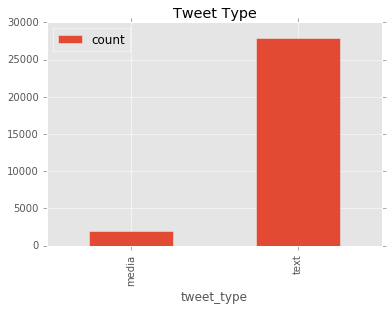

In [38]:
df.groupby('tweet_type')['twitter_id'].agg(['count']).plot(kind='bar', title='Tweet Type')

tweet_type
media    Axes(0.125,0.2;0.775x0.7)
text     Axes(0.125,0.2;0.775x0.7)
Name: count, dtype: object

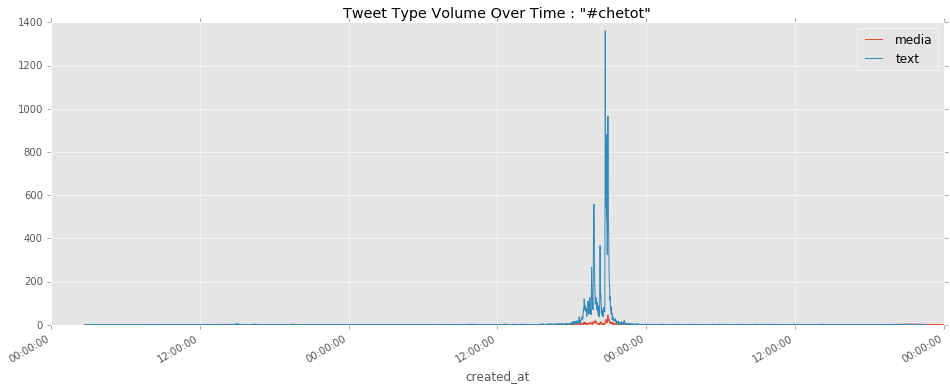

In [39]:
#reindex to datetime, groupby hour and tweet type, count id's
d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='T'), 'tweet_type'])['twitter_id'].agg(['count'])
#reset index groupby object for time series plotting
d = d.reset_index().set_index('created_at')
#plot count by retweet category
d.groupby('tweet_type')['count'].plot(figsize=(16,6),
                                      legend=True,
                                      xlim=(start, finish),
                                      title='Tweet Type Volume Over Time : "%s"' % keyword)

#### source utility
* plot tweet counts by top 10 source utility

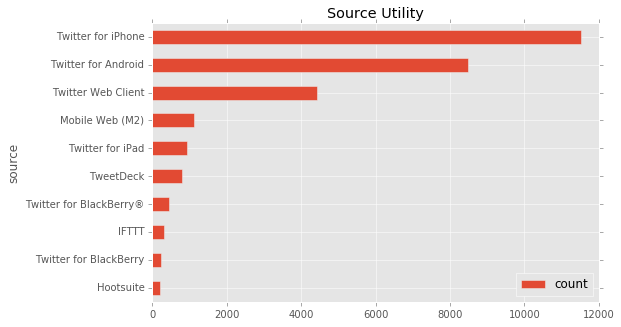

In [40]:
df.groupby('source')['twitter_id'].agg(['count']).sort_values(by='count', ascending=True)[-10:].plot(kind='barh', figsize=(8,5), title='Source Utility')

#### source place
* plot tweet counts by top 10 place names
* this data is user specificed, and not consistent/clean

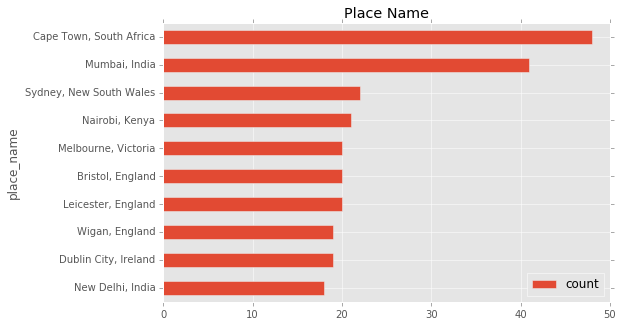

In [41]:
df.groupby('place_name')['twitter_id'].agg(['count']).sort_values(by='count', ascending=True)[-10:].plot(kind='barh', figsize=(8,5), title='Place Name')

#### tweet attributes
* our search excluded retweets already
* although we can see how many, if any, fell through the cracks
* look at percent of quotes and replies which also will not be used in final summary

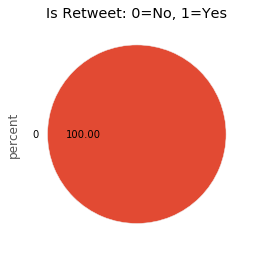

In [42]:
#How many retweets v non?
d = df.groupby('is_retweet')['twitter_id'].agg(['count'])
d['percent'] = d['count']/df.shape[0]
d['percent'].plot(kind='pie',
                  figsize=[4,4],
                  autopct='%.2f',
                  title='Is Retweet: 0=No, 1=Yes')

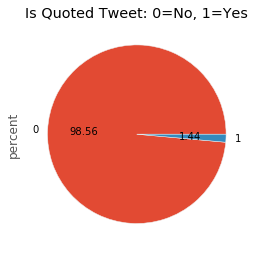

In [43]:
#How many quoted tweets v non?
d = df.groupby('is_quoted_tweet')['twitter_id'].agg(['count'])
d['percent'] = d['count']/df.shape[0]
d['percent'].plot(kind='pie',
                  figsize=[4,4],
                  autopct='%.2f',
                  title='Is Quoted Tweet: 0=No, 1=Yes')

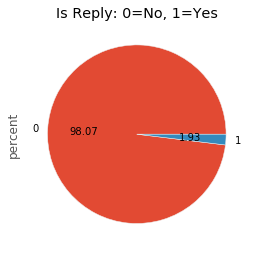

In [44]:
#How many replies v non?
d = df.groupby('is_reply')['twitter_id'].agg(['count'])
d['percent'] = d['count']/df.shape[0]
#d['percent'].plot(kind='bar', ylim=[0,1])
d['percent'].plot(kind='pie',
                  figsize=[4,4],
                  autopct='%.2f',
                  title='Is Reply: 0=No, 1=Yes')